# **ARI 7:2:1**

## **Thuật toán AAE**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
fileName = '/content/ARI-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]


In [ ]:
dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,16.54,16.49,16.55,16.35,184.56K,1.10%
2127,01/05/2015,16.51,16.47,16.63,16.45,387.43K,-0.18%
2126,01/06/2015,16.42,16.60,16.64,16.37,225.81K,-0.55%
2125,01/07/2015,16.63,16.48,16.65,16.44,492.81K,1.28%
2124,01/08/2015,16.49,16.69,16.69,16.45,440.70K,-0.84%


In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)

In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)


In [ ]:
data_transform = dataset.drop('Date', axis=1)
data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
# data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data_transform=scaler.fit_transform(np.array(data_transform))

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 4

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    # sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [ ]:
batch_size=512
n_epochs=50

In [ ]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [ ]:
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/50] [Batch 0/5] [D loss: 0.657806] [G loss: 0.125520]
[Epoch 4/50] [Batch 1/5] [D loss: 0.654211] [G loss: 0.188686]
[Epoch 4/50] [Batch 2/5] [D loss: 0.643992] [G loss: 0.137315]
[Epoch 4/50] [Batch 3/5] [D loss: 0.653787] [G loss: 0.132596]
[Epoch 4/50] [Batch 4/5] [D loss: 0.624412] [G loss: 0.267459]
[Epoch 9/50] [Batch 0/5] [D loss: 0.576214] [G loss: 0.126731]
[Epoch 9/50] [Batch 1/5] [D loss: 0.583190] [G loss: 0.157247]
[Epoch 9/50] [Batch 2/5] [D loss: 0.550500] [G loss: 0.068298]
[Epoch 9/50] [Batch 3/5] [D loss: 0.564925] [G loss: 0.121775]
[Epoch 9/50] [Batch 4/5] [D loss: 0.590887] [G loss: 0.228548]
[Epoch 14/50] [Batch 0/5] [D loss: 0.557881] [G loss: 0.093771]
[Epoch 14/50] [Batch 1/5] [D loss: 0.563874] [G loss: 0.173381]
[Epoch 14/50] [Batch 2/5] [D loss: 0.554165] [G loss: 0.086587]
[Epoch 14/50] [Batch 3/5] [D loss: 0.546720] [G loss: 0.107087]
[Epoch 14/50] [Batch 4/5] [D loss: 0.570156] [G loss: 0.191308]
[Epoch 19/50] [Batch 0/5] [D loss: 0.580977] [G lo

In [ ]:
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()


In [ ]:
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()

In [ ]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()

## **Thuật toán LSTM**


In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
24/24 [==============================] - 12s 87ms/step - loss: 0.1373 - val_loss: 0.2852
Epoch 2/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0490 - val_loss: 0.0324
Epoch 3/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0205 - val_loss: 0.0514
Epoch 4/50
24/24 [==============================] - 0s 14ms/step - loss: 0.0166 - val_loss: 0.0259
Epoch 5/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0128 - val_loss: 0.0134
Epoch 6/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0077
Epoch 7/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0074 - val_loss: 0.0037
Epoch 8/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0070 - val_loss: 0.0026
Epoch 9/50
24/24 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 0.0033
Epoch 10/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0030
Epoch 11

In [ ]:
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 4ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.4903660812108855
Testing RMSE: 0.5832863418034243
Testing MAE: 0.5260460077560828
Validation MAE: 0.4121273542800041
Testing MAPE: 3.9111847451053046
Validation MAPE: 3.7080585343447248


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

## **kẾT QUẢ**

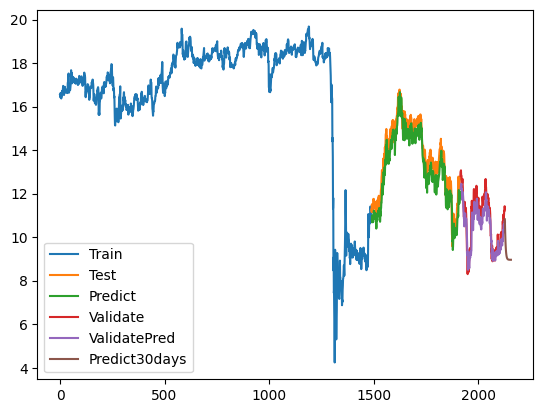

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# **MAA 7:2:1**

## **Thuật toán AAE**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
fileName = '/content/MAA-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]


In [ ]:
dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,76.15,74.47,76.19,74.47,276.36K,1.97%
2127,01/05/2015,75.86,75.86,76.34,75.43,549.69K,-0.38%
2126,01/06/2015,77.18,76.28,77.83,76.27,833.74K,1.74%
2125,01/07/2015,78.14,76.48,78.34,76.29,544.77K,1.24%
2124,01/08/2015,78.34,78.14,78.46,77.36,544.03K,0.26%


In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)

In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)


In [ ]:
data_transform = dataset.drop('Date', axis=1)
data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data_transform=scaler.fit_transform(np.array(data_transform))

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 3

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    # sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [ ]:
batch_size=512
n_epochs=50

In [ ]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [ ]:
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/50] [Batch 0/5] [D loss: 0.621600] [G loss: 0.198419]
[Epoch 4/50] [Batch 1/5] [D loss: 0.629698] [G loss: 0.138975]
[Epoch 4/50] [Batch 2/5] [D loss: 0.627912] [G loss: 0.294409]
[Epoch 4/50] [Batch 3/5] [D loss: 0.608112] [G loss: 0.167887]
[Epoch 4/50] [Batch 4/5] [D loss: 0.614123] [G loss: 0.135189]
[Epoch 9/50] [Batch 0/5] [D loss: 0.596251] [G loss: 0.160038]
[Epoch 9/50] [Batch 1/5] [D loss: 0.609366] [G loss: 0.140164]
[Epoch 9/50] [Batch 2/5] [D loss: 0.614138] [G loss: 0.260651]
[Epoch 9/50] [Batch 3/5] [D loss: 0.576542] [G loss: 0.140281]
[Epoch 9/50] [Batch 4/5] [D loss: 0.581276] [G loss: 0.148147]
[Epoch 14/50] [Batch 0/5] [D loss: 0.624786] [G loss: 0.148384]
[Epoch 14/50] [Batch 1/5] [D loss: 0.630172] [G loss: 0.096608]
[Epoch 14/50] [Batch 2/5] [D loss: 0.641577] [G loss: 0.229740]
[Epoch 14/50] [Batch 3/5] [D loss: 0.541396] [G loss: 0.158379]
[Epoch 14/50] [Batch 4/5] [D loss: 0.585588] [G loss: 0.101057]
[Epoch 19/50] [Batch 0/5] [D loss: 0.592327] [G lo

In [ ]:
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()


In [ ]:
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()

In [ ]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()

## **Thuật toán LSTM**


In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
24/24 [==============================] - 9s 69ms/step - loss: 0.3325 - val_loss: 0.1672
Epoch 2/50
24/24 [==============================] - 0s 11ms/step - loss: 0.1309 - val_loss: 0.0058
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0072
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0122
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 6/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9476e-04 - val_loss: 0.0103
Epoch 7/50
24/24 [==============================] - 0s 11ms/step - loss: 9.9993e-04 - val_loss: 0.0102
Epoch 8/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0103
Epoch 9/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9496e-04 - val_loss: 0.0100
Epoch 10/50
24/24 [==============================] - 0s 8ms/step - loss: 9.9153e-04 - val_loss: 0.0104


In [ ]:
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 3ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 11.830722115939931
Testing RMSE: 22.023284104771275
Testing MAE: 18.95880455071199
Validation MAE: 10.52458277864276
Testing MAPE: 10.925394111957127
Validation MAPE: 6.871273224810043


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
lst_output

[[0.6005980968475342],
 [0.6185290813446045],
 [0.6231992244720459],
 [0.6244164705276489],
 [0.6247338056564331],
 [0.6248164176940918],
 [0.6248379945755005],
 [0.6248437166213989],
 [0.6248451471328735],
 [0.6248455047607422],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317]]

## **kẾT QUẢ**

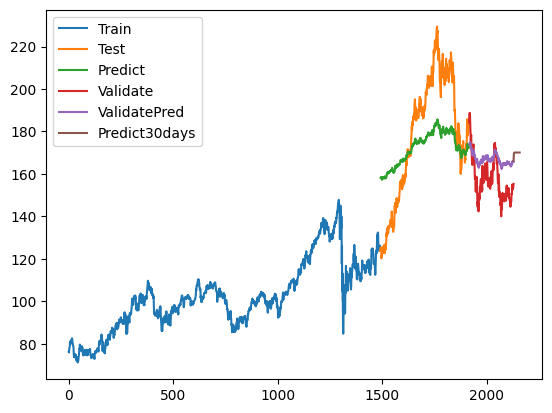

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# **ARE 7:2:1**

## **Thuật toán AAE**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
fileName = '/content/ARE-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]


In [ ]:
dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,89.79,89.11,89.88,88.54,277.62K,1.18%
2127,01/05/2015,90.87,89.31,91.17,89.15,359.76K,1.20%
2126,01/06/2015,91.33,90.65,91.56,90.25,1.33M,0.51%
2125,01/07/2015,92.57,91.55,92.57,90.69,543.40K,1.36%
2124,01/08/2015,93.63,92.57,93.85,92.43,718.78K,1.15%


In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)

In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)


In [ ]:
data_transform = dataset.drop('Date', axis=1)
# data_transform = data_transform.drop('Open', axis=1)
# data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)ARI 6:2:2
Thuật toán AAE
[ ]
from google.colab import drive
drive.mount('/content/drive')
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[ ]
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
[ ]
fileName = '/content/ARI-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]

[ ]
dataset.head()

[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)
[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)

[ ]
data_transform = dataset.drop('Date', axis=1)
data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
# data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)

[ ]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
[ ]
data_transform=scaler.fit_transform(np.array(data_transform))
[ ]
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 4

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    # sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity



[ ]
batch_size=512
n_epochs=50
[ ]
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)
[ ]
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)

[ ]
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)
[ ]
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )
[Epoch 4/50] [Batch 0/5] [D loss: 0.685623] [G loss: 0.124850]
[Epoch 4/50] [Batch 1/5] [D loss: 0.685128] [G loss: 0.169978]
[Epoch 4/50] [Batch 2/5] [D loss: 0.690018] [G loss: 0.242292]
[Epoch 4/50] [Batch 3/5] [D loss: 0.699014] [G loss: 0.167520]
[Epoch 4/50] [Batch 4/5] [D loss: 0.688109] [G loss: 0.293190]
[Epoch 9/50] [Batch 0/5] [D loss: 0.678914] [G loss: 0.070743]
[Epoch 9/50] [Batch 1/5] [D loss: 0.680909] [G loss: 0.135947]
[Epoch 9/50] [Batch 2/5] [D loss: 0.675824] [G loss: 0.134671]
[Epoch 9/50] [Batch 3/5] [D loss: 0.681503] [G loss: 0.129385]
[Epoch 9/50] [Batch 4/5] [D loss: 0.697035] [G loss: 0.234515]
[Epoch 14/50] [Batch 0/5] [D loss: 0.654295] [G loss: 0.053043]
[Epoch 14/50] [Batch 1/5] [D loss: 0.648459] [G loss: 0.130897]
[Epoch 14/50] [Batch 2/5] [D loss: 0.649100] [G loss: 0.093655]
[Epoch 14/50] [Batch 3/5] [D loss: 0.668025] [G loss: 0.155134]
[Epoch 14/50] [Batch 4/5] [D loss: 0.683296] [G loss: 0.263833]
[Epoch 19/50] [Batch 0/5] [D loss: 0.651021] [G loss: 0.060532]
[Epoch 19/50] [Batch 1/5] [D loss: 0.651261] [G loss: 0.132216]
[Epoch 19/50] [Batch 2/5] [D loss: 0.660011] [G loss: 0.244908]
[Epoch 19/50] [Batch 3/5] [D loss: 0.665665] [G loss: 0.129113]
[Epoch 19/50] [Batch 4/5] [D loss: 0.684255] [G loss: 0.174493]
[Epoch 24/50] [Batch 0/5] [D loss: 0.633654] [G loss: 0.047057]
[Epoch 24/50] [Batch 1/5] [D loss: 0.632475] [G loss: 0.121372]
[Epoch 24/50] [Batch 2/5] [D loss: 0.601512] [G loss: 0.140329]
[Epoch 24/50] [Batch 3/5] [D loss: 0.630448] [G loss: 0.117246]
[Epoch 24/50] [Batch 4/5] [D loss: 0.634716] [G loss: 0.161684]
[Epoch 29/50] [Batch 0/5] [D loss: 0.606842] [G loss: 0.073620]
[Epoch 29/50] [Batch 1/5] [D loss: 0.611867] [G loss: 0.126384]
[Epoch 29/50] [Batch 2/5] [D loss: 0.597674] [G loss: 0.115299]
[Epoch 29/50] [Batch 3/5] [D loss: 0.658244] [G loss: 0.106119]
[Epoch 29/50] [Batch 4/5] [D loss: 0.674665] [G loss: 0.204117]
[Epoch 34/50] [Batch 0/5] [D loss: 0.609658] [G loss: 0.047981]
[Epoch 34/50] [Batch 1/5] [D loss: 0.613415] [G loss: 0.105840]
[Epoch 34/50] [Batch 2/5] [D loss: 0.591173] [G loss: 0.087569]
[Epoch 34/50] [Batch 3/5] [D loss: 0.619519] [G loss: 0.088659]
[Epoch 34/50] [Batch 4/5] [D loss: 0.654603] [G loss: 0.144283]
[Epoch 39/50] [Batch 0/5] [D loss: 0.591907] [G loss: 0.058296]
[Epoch 39/50] [Batch 1/5] [D loss: 0.594976] [G loss: 0.094423]
[Epoch 39/50] [Batch 2/5] [D loss: 0.581190] [G loss: 0.112344]
[Epoch 39/50] [Batch 3/5] [D loss: 0.610624] [G loss: 0.106713]
[Epoch 39/50] [Batch 4/5] [D loss: 0.696877] [G loss: 0.171685]
[Epoch 44/50] [Batch 0/5] [D loss: 0.651506] [G loss: 0.036847]
[Epoch 44/50] [Batch 1/5] [D loss: 0.631059] [G loss: 0.085046]
[Epoch 44/50] [Batch 2/5] [D loss: 0.615199] [G loss: 0.085766]
[Epoch 44/50] [Batch 3/5] [D loss: 0.629683] [G loss: 0.097428]
[Epoch 44/50] [Batch 4/5] [D loss: 0.671348] [G loss: 0.120956]
[Epoch 49/50] [Batch 0/5] [D loss: 0.632694] [G loss: 0.052743]
[Epoch 49/50] [Batch 1/5] [D loss: 0.633533] [G loss: 0.088657]
[Epoch 49/50] [Batch 2/5] [D loss: 0.616943] [G loss: 0.095644]
[Epoch 49/50] [Batch 3/5] [D loss: 0.619125] [G loss: 0.102758]
[Epoch 49/50] [Batch 4/5] [D loss: 0.598600] [G loss: 0.122058]
[ ]
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()

[ ]
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()
[ ]
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()
Thuật toán LSTM
[ ]
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
[ ]
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()

[ ]
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
[ ]
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]
[ ]
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
[ ]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
[ ]
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
[ ]
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
[ ]
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)
Epoch 1/50
20/20 [==============================] - 7s 62ms/step - loss: 0.1128 - val_loss: 0.0132
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0441 - val_loss: 0.0278
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0527
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0434
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0456
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0444
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0426
Epoch 8/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0411
Epoch 9/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0396
Epoch 10/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0359
Epoch 11/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0342
Epoch 12/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0332
Epoch 13/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0290
Epoch 14/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0264
Epoch 15/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0221
Epoch 16/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0197
Epoch 17/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0166
Epoch 18/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0148
Epoch 19/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0134
Epoch 20/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0122
Epoch 21/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0117
Epoch 22/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0111
Epoch 23/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0110
Epoch 24/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0106
Epoch 25/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0105
Epoch 26/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0098
Epoch 27/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 28/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 29/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0107
Epoch 30/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0107
Epoch 31/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 32/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0106
Epoch 33/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 34/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 35/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 36/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0106
Epoch 37/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0109
Epoch 38/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0109
Epoch 39/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0111
Epoch 40/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0118
Epoch 41/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 42/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0110
Epoch 43/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0110
Epoch 44/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0113
Epoch 45/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0112
Epoch 46/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0109
Epoch 47/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0118
Epoch 48/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 49/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0117
Epoch 50/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0110
<keras.callbacks.History at 0x7f9ad43698d0>
[ ]
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

[ ]
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)
40/40 [==============================] - 1s 3ms/step
14/14 [==============================] - 0s 3ms/step
14/14 [==============================] - 0s 3ms/step
[ ]
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))
Đánh giá
[ ]
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)
Validation RMSE: 0.382459268077301
Testing RMSE: 0.6263239572632049
Testing MAE: 0.4272109810849454
Validation MAE: 0.31409084885541155
Testing MAPE: 3.8795289642060196
Validation MAPE: 2.655388727557074
[ ]
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{\} day input {\}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{\} day output {\}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
kẾT QUẢ
[ ]
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

ARE 6:2:2
Thuật toán AAE
[ ]
from google.colab import drive
drive.mount('/content/drive')
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[ ]
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
[ ]
fileName = '/content/ARE-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]

[ ]
dataset.head()

[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)
[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)

[ ]
data_transform = dataset.drop('Date', axis=1)
# data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)

[ ]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
[ ]
data_transform=scaler.fit_transform(np.array(data_transform))
[ ]
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 4

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity



[ ]
batch_size=512
n_epochs=50
[ ]
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)
[ ]
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)

[ ]
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)
[ ]
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )
[Epoch 4/50] [Batch 0/5] [D loss: 0.648370] [G loss: 0.171625]
[Epoch 4/50] [Batch 1/5] [D loss: 0.631796] [G loss: 0.105395]
[Epoch 4/50] [Batch 2/5] [D loss: 0.637421] [G loss: 0.107772]
[Epoch 4/50] [Batch 3/5] [D loss: 0.618283] [G loss: 0.142547]
[Epoch 4/50] [Batch 4/5] [D loss: 0.650845] [G loss: 0.081581]
[Epoch 9/50] [Batch 0/5] [D loss: 0.614487] [G loss: 0.117618]
[Epoch 9/50] [Batch 1/5] [D loss: 0.590858] [G loss: 0.108956]
[Epoch 9/50] [Batch 2/5] [D loss: 0.555192] [G loss: 0.114140]
[Epoch 9/50] [Batch 3/5] [D loss: 0.549742] [G loss: 0.092619]
[Epoch 9/50] [Batch 4/5] [D loss: 0.629552] [G loss: 0.085013]
[Epoch 14/50] [Batch 0/5] [D loss: 0.620113] [G loss: 0.134530]
[Epoch 14/50] [Batch 1/5] [D loss: 0.598548] [G loss: 0.099031]
[Epoch 14/50] [Batch 2/5] [D loss: 0.562913] [G loss: 0.080471]
[Epoch 14/50] [Batch 3/5] [D loss: 0.502876] [G loss: 0.151586]
[Epoch 14/50] [Batch 4/5] [D loss: 0.618096] [G loss: 0.078569]
[Epoch 19/50] [Batch 0/5] [D loss: 0.645010] [G loss: 0.119800]
[Epoch 19/50] [Batch 1/5] [D loss: 0.654467] [G loss: 0.050480]
[Epoch 19/50] [Batch 2/5] [D loss: 0.566331] [G loss: 0.075438]
[Epoch 19/50] [Batch 3/5] [D loss: 0.515696] [G loss: 0.099483]
[Epoch 19/50] [Batch 4/5] [D loss: 0.649332] [G loss: 0.066649]
[Epoch 24/50] [Batch 0/5] [D loss: 0.628371] [G loss: 0.150580]
[Epoch 24/50] [Batch 1/5] [D loss: 0.615519] [G loss: 0.058986]
[Epoch 24/50] [Batch 2/5] [D loss: 0.558291] [G loss: 0.077531]
[Epoch 24/50] [Batch 3/5] [D loss: 0.487969] [G loss: 0.103786]
[Epoch 24/50] [Batch 4/5] [D loss: 0.642708] [G loss: 0.083261]
[Epoch 29/50] [Batch 0/5] [D loss: 0.681057] [G loss: 0.101448]
[Epoch 29/50] [Batch 1/5] [D loss: 0.639620] [G loss: 0.073123]
[Epoch 29/50] [Batch 2/5] [D loss: 0.582013] [G loss: 0.063524]
[Epoch 29/50] [Batch 3/5] [D loss: 0.490078] [G loss: 0.084015]
[Epoch 29/50] [Batch 4/5] [D loss: 0.639243] [G loss: 0.094247]
[Epoch 34/50] [Batch 0/5] [D loss: 0.643637] [G loss: 0.130100]
[Epoch 34/50] [Batch 1/5] [D loss: 0.633293] [G loss: 0.115243]
[Epoch 34/50] [Batch 2/5] [D loss: 0.532761] [G loss: 0.076712]
[Epoch 34/50] [Batch 3/5] [D loss: 0.492688] [G loss: 0.091054]
[Epoch 34/50] [Batch 4/5] [D loss: 0.599211] [G loss: 0.066733]
[Epoch 39/50] [Batch 0/5] [D loss: 0.637879] [G loss: 0.118838]
[Epoch 39/50] [Batch 1/5] [D loss: 0.621423] [G loss: 0.055370]
[Epoch 39/50] [Batch 2/5] [D loss: 0.565127] [G loss: 0.063454]
[Epoch 39/50] [Batch 3/5] [D loss: 0.458828] [G loss: 0.083397]
[Epoch 39/50] [Batch 4/5] [D loss: 0.638964] [G loss: 0.066822]
[Epoch 44/50] [Batch 0/5] [D loss: 0.646537] [G loss: 0.090059]
[Epoch 44/50] [Batch 1/5] [D loss: 0.607167] [G loss: 0.062084]
[Epoch 44/50] [Batch 2/5] [D loss: 0.550125] [G loss: 0.061432]
[Epoch 44/50] [Batch 3/5] [D loss: 0.452766] [G loss: 0.065491]
[Epoch 44/50] [Batch 4/5] [D loss: 0.589808] [G loss: 0.062634]
[Epoch 49/50] [Batch 0/5] [D loss: 0.669522] [G loss: 0.094454]
[Epoch 49/50] [Batch 1/5] [D loss: 0.631256] [G loss: 0.066661]
[Epoch 49/50] [Batch 2/5] [D loss: 0.578475] [G loss: 0.067836]
[Epoch 49/50] [Batch 3/5] [D loss: 0.478711] [G loss: 0.075519]
[Epoch 49/50] [Batch 4/5] [D loss: 0.635596] [G loss: 0.070984]
[ ]
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()

[ ]
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()
[ ]
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()
Thuật toán LSTM
[ ]
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
[ ]
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()

[ ]
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
[ ]
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]
[ ]
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
[ ]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
[ ]
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
[ ]
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
[ ]
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)
Epoch 1/50
20/20 [==============================] - 7s 63ms/step - loss: 0.0809 - val_loss: 0.1441
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0284 - val_loss: 0.0390
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0248
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0279
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0267
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0264
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0266
Epoch 8/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0263
Epoch 9/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0278
Epoch 10/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0259
Epoch 11/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0266
Epoch 12/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0259
Epoch 13/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0253
Epoch 14/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0256
Epoch 15/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0248
Epoch 16/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0256
Epoch 17/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0254
Epoch 18/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0248
Epoch 19/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0264
Epoch 20/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0242
Epoch 21/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0243
Epoch 22/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0238
Epoch 23/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0229
Epoch 24/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0238
Epoch 25/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0233
Epoch 26/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0228
Epoch 27/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0249
Epoch 28/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0234
Epoch 29/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0222
Epoch 30/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0223
Epoch 31/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0216
Epoch 32/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0208
Epoch 33/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0209
Epoch 34/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0210
Epoch 35/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0211
Epoch 36/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0209
Epoch 37/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0210
Epoch 38/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0208
Epoch 39/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0207
Epoch 40/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0201
Epoch 41/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0206
Epoch 42/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0195
Epoch 43/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0195
Epoch 44/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0194
Epoch 45/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0209
Epoch 46/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0193
Epoch 47/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0201
Epoch 48/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0195
Epoch 49/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0201
Epoch 50/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0200
<keras.callbacks.History at 0x7fc30a31f640>
[ ]
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

[ ]
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)
40/40 [==============================] - 1s 4ms/step
14/14 [==============================] - 0s 5ms/step
14/14 [==============================] - 0s 5ms/step
[ ]
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))
Đánh giá
[ ]
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)
Validation RMSE: 28.81628755248695
Testing RMSE: 29.760322080452053
Testing MAE: 28.507130765441467
Validation MAE: 24.345847875258503
Testing MAPE: 16.430672117713343
Validation MAPE: 13.649430526365977
[ ]
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{\} day input {\}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{\} day output {\}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
[ ]
lst_output
[[0.30174869298934937],
 [0.3069173991680145],
 [0.30891919136047363],
 [0.3096965551376343],
 [0.3099987208843231],
 [0.3101162612438202],
 [0.3101619780063629],
 [0.310179740190506],
 [0.3101866543292999],
 [0.3101893365383148],
 [0.3101904094219208],
 [0.3101908266544342],
 [0.31019094586372375],
 [0.31019100546836853],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909]]
kẾT QUẢ
[ ]
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

MAA 6:2:2
Thuật toán AAE
[ ]
from google.colab import drive
drive.mount('/content/drive')
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[ ]
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
[ ]
fileName = '/content/MAA-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]


[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)
[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)

[ ]
data_transform = dataset.drop('Date', axis=1)
# data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
data_transform = data_transform.drop('Change %', axis=1)
data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)

[ ]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
[ ]
data_transform=scaler.fit_transform(np.array(data_transform))
[ ]
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 3

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    # sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity



[ ]
batch_size=512
n_epochs=50
[ ]
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)
[ ]
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)

[ ]
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)
[ ]
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )
[Epoch 4/50] [Batch 0/5] [D loss: 0.572098] [G loss: 0.282921]
[Epoch 4/50] [Batch 1/5] [D loss: 0.612416] [G loss: 0.207775]
[Epoch 4/50] [Batch 2/5] [D loss: 0.625077] [G loss: 0.068381]
[Epoch 4/50] [Batch 3/5] [D loss: 0.617851] [G loss: 0.117101]
[Epoch 4/50] [Batch 4/5] [D loss: 0.593049] [G loss: 0.260517]
[Epoch 9/50] [Batch 0/5] [D loss: 0.498585] [G loss: 0.227818]
[Epoch 9/50] [Batch 1/5] [D loss: 0.565717] [G loss: 0.090372]
[Epoch 9/50] [Batch 2/5] [D loss: 0.606138] [G loss: 0.111451]
[Epoch 9/50] [Batch 3/5] [D loss: 0.616360] [G loss: 0.077883]
[Epoch 9/50] [Batch 4/5] [D loss: 0.615737] [G loss: 0.140351]
[Epoch 14/50] [Batch 0/5] [D loss: 0.479387] [G loss: 0.213256]
[Epoch 14/50] [Batch 1/5] [D loss: 0.540890] [G loss: 0.085657]
[Epoch 14/50] [Batch 2/5] [D loss: 0.624081] [G loss: 0.090392]
[Epoch 14/50] [Batch 3/5] [D loss: 0.637836] [G loss: 0.077798]
[Epoch 14/50] [Batch 4/5] [D loss: 0.599403] [G loss: 0.203277]
[Epoch 19/50] [Batch 0/5] [D loss: 0.470901] [G loss: 0.240951]
[Epoch 19/50] [Batch 1/5] [D loss: 0.554769] [G loss: 0.104830]
[Epoch 19/50] [Batch 2/5] [D loss: 0.637395] [G loss: 0.083064]
[Epoch 19/50] [Batch 3/5] [D loss: 0.635104] [G loss: 0.082248]
[Epoch 19/50] [Batch 4/5] [D loss: 0.619354] [G loss: 0.186696]
[Epoch 24/50] [Batch 0/5] [D loss: 0.448517] [G loss: 0.258658]
[Epoch 24/50] [Batch 1/5] [D loss: 0.520946] [G loss: 0.077970]
[Epoch 24/50] [Batch 2/5] [D loss: 0.617939] [G loss: 0.050018]
[Epoch 24/50] [Batch 3/5] [D loss: 0.622293] [G loss: 0.067619]
[Epoch 24/50] [Batch 4/5] [D loss: 0.570606] [G loss: 0.238930]
[Epoch 29/50] [Batch 0/5] [D loss: 0.441476] [G loss: 0.191101]
[Epoch 29/50] [Batch 1/5] [D loss: 0.569248] [G loss: 0.094756]
[Epoch 29/50] [Batch 2/5] [D loss: 0.687605] [G loss: 0.067794]
[Epoch 29/50] [Batch 3/5] [D loss: 0.687927] [G loss: 0.073200]
[Epoch 29/50] [Batch 4/5] [D loss: 0.644505] [G loss: 0.138414]
[Epoch 34/50] [Batch 0/5] [D loss: 0.461111] [G loss: 0.169764]
[Epoch 34/50] [Batch 1/5] [D loss: 0.560707] [G loss: 0.074007]
[Epoch 34/50] [Batch 2/5] [D loss: 0.657023] [G loss: 0.046695]
[Epoch 34/50] [Batch 3/5] [D loss: 0.651555] [G loss: 0.096018]
[Epoch 34/50] [Batch 4/5] [D loss: 0.642956] [G loss: 0.154190]
[Epoch 39/50] [Batch 0/5] [D loss: 0.430717] [G loss: 0.156485]
[Epoch 39/50] [Batch 1/5] [D loss: 0.558925] [G loss: 0.087963]
[Epoch 39/50] [Batch 2/5] [D loss: 0.677332] [G loss: 0.062921]
[Epoch 39/50] [Batch 3/5] [D loss: 0.653166] [G loss: 0.087385]
[Epoch 39/50] [Batch 4/5] [D loss: 0.630541] [G loss: 0.156071]
[Epoch 44/50] [Batch 0/5] [D loss: 0.437807] [G loss: 0.138233]
[Epoch 44/50] [Batch 1/5] [D loss: 0.589224] [G loss: 0.079710]
[Epoch 44/50] [Batch 2/5] [D loss: 0.686020] [G loss: 0.054585]
[Epoch 44/50] [Batch 3/5] [D loss: 0.668507] [G loss: 0.063418]
[Epoch 44/50] [Batch 4/5] [D loss: 0.635201] [G loss: 0.164315]
[Epoch 49/50] [Batch 0/5] [D loss: 0.467086] [G loss: 0.142949]
[Epoch 49/50] [Batch 1/5] [D loss: 0.565477] [G loss: 0.059526]
[Epoch 49/50] [Batch 2/5] [D loss: 0.650224] [G loss: 0.048327]
[Epoch 49/50] [Batch 3/5] [D loss: 0.642140] [G loss: 0.090988]
[Epoch 49/50] [Batch 4/5] [D loss: 0.626740] [G loss: 0.091704]
[ ]
import matplotlib.pyplot as plt
# Vẽ biểu đồ Discriminator Loss
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator Loss')
plt.show()


[ ]
# Vẽ biểu đồ Generator Loss
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator Loss')
plt.show()

[ ]
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()
Thuật toán LSTM
[ ]
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
[ ]
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()

[ ]
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
[ ]
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]
[ ]
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
[ ]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
[ ]
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
[ ]
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
[ ]
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)
Epoch 1/50
20/20 [==============================] - 8s 83ms/step - loss: 0.1711 - val_loss: 0.1871
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0830 - val_loss: 0.0430
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0048
Epoch 4/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.0075
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0095 - val_loss: 0.0069
Epoch 7/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 8/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 9/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 10/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 11/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 12/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0084
Epoch 13/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0088
Epoch 14/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0088
Epoch 15/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0088
Epoch 16/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0088
Epoch 17/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 18/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 19/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 20/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 21/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 22/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0028 - val_loss: 0.0086
Epoch 23/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 24/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 25/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0084
Epoch 26/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0086
Epoch 27/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0083
Epoch 28/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0083
Epoch 29/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 30/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 31/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 32/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 33/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 34/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 35/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 36/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0080
Epoch 37/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0079
Epoch 38/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 39/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 40/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 41/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 42/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0081
Epoch 43/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 44/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 45/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 46/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0074
Epoch 47/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 48/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 49/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 50/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0073
<keras.callbacks.History at 0x7f68a18ebf40>
[ ]
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']


# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

[ ]
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)
40/40 [==============================] - 2s 3ms/step
14/14 [==============================] - 0s 3ms/step
14/14 [==============================] - 0s 4ms/step
[ ]
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))
Đánh giá
[ ]
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)
Validation RMSE: 10.466122463527656
Testing RMSE: 5.080083527111531
Testing MAE: 3.646465322796616
Validation MAE: 8.000601258042279
Testing MAPE: 2.5059650398515614
Validation MAPE: 4.113629445444246
[ ]
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{\} day input {\}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{\} day output {\}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
[ ]
lst_output
[[0.5186550617218018],
 [0.5078740119934082],
 [0.4987865388393402],
 [0.4910713732242584],
 [0.4844813644886017],
 [0.47882354259490967],
 [0.4739447832107544],
 [0.4697220027446747],
 [0.46605512499809265],
 [0.4628620445728302],
 [0.460074782371521],
 [0.4576367139816284],
 [0.45550015568733215],
 [0.4536247253417969],
 [0.45197615027427673],
 [0.45052528381347656],
 [0.4492470920085907],
 [0.44811975955963135],
 [0.4471248984336853],
 [0.44624605774879456],
 [0.44546931982040405],
 [0.4447823762893677],
 [0.44417455792427063],
 [0.44363656640052795],
 [0.4431599974632263],
 [0.4427378475666046],
 [0.44236376881599426],
 [0.44203224778175354],
 [0.4417383372783661],
 [0.4414776563644409]]
kẾT QUẢ
[ ]
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)


ARI 7:2:1
Thuật toán AAE
[ ]
↳ 18 cells hidden
Thuật toán LSTM
[ ]
↳ 12 cells hidden
Đánh giá
[ ]
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)
Validation RMSE: 0.4903660812108855
Testing RMSE: 0.5832863418034243
Testing MAE: 0.5260460077560828
Validation MAE: 0.4121273542800041
Testing MAPE: 3.9111847451053046
Validation MAPE: 3.7080585343447248
[ ]
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{\} day input {\}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{\} day output {\}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
kẾT QUẢ
[ ]
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

MAA 7:2:1
Thuật toán AAE
[ ]
from google.colab import drive
drive.mount('/content/drive')
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[ ]
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
[ ]
fileName = '/content/MAA-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]

[ ]
dataset.head()

[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)
[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)

[ ]
data_transform = dataset.drop('Date', axis=1)
data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)

[ ]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
[ ]
data_transform=scaler.fit_transform(np.array(data_transform))
[ ]
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 3

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    # sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity



[ ]
batch_size=512
n_epochs=50
[ ]
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)
[ ]
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)

[ ]
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)
[ ]
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )
[Epoch 4/50] [Batch 0/5] [D loss: 0.621600] [G loss: 0.198419]
[Epoch 4/50] [Batch 1/5] [D loss: 0.629698] [G loss: 0.138975]
[Epoch 4/50] [Batch 2/5] [D loss: 0.627912] [G loss: 0.294409]
[Epoch 4/50] [Batch 3/5] [D loss: 0.608112] [G loss: 0.167887]
[Epoch 4/50] [Batch 4/5] [D loss: 0.614123] [G loss: 0.135189]
[Epoch 9/50] [Batch 0/5] [D loss: 0.596251] [G loss: 0.160038]
[Epoch 9/50] [Batch 1/5] [D loss: 0.609366] [G loss: 0.140164]
[Epoch 9/50] [Batch 2/5] [D loss: 0.614138] [G loss: 0.260651]
[Epoch 9/50] [Batch 3/5] [D loss: 0.576542] [G loss: 0.140281]
[Epoch 9/50] [Batch 4/5] [D loss: 0.581276] [G loss: 0.148147]
[Epoch 14/50] [Batch 0/5] [D loss: 0.624786] [G loss: 0.148384]
[Epoch 14/50] [Batch 1/5] [D loss: 0.630172] [G loss: 0.096608]
[Epoch 14/50] [Batch 2/5] [D loss: 0.641577] [G loss: 0.229740]
[Epoch 14/50] [Batch 3/5] [D loss: 0.541396] [G loss: 0.158379]
[Epoch 14/50] [Batch 4/5] [D loss: 0.585588] [G loss: 0.101057]
[Epoch 19/50] [Batch 0/5] [D loss: 0.592327] [G loss: 0.208296]
[Epoch 19/50] [Batch 1/5] [D loss: 0.599800] [G loss: 0.167866]
[Epoch 19/50] [Batch 2/5] [D loss: 0.620899] [G loss: 0.106873]
[Epoch 19/50] [Batch 3/5] [D loss: 0.504897] [G loss: 0.154611]
[Epoch 19/50] [Batch 4/5] [D loss: 0.604066] [G loss: 0.140487]
[Epoch 24/50] [Batch 0/5] [D loss: 0.640020] [G loss: 0.116963]
[Epoch 24/50] [Batch 1/5] [D loss: 0.620201] [G loss: 0.070174]
[Epoch 24/50] [Batch 2/5] [D loss: 0.643912] [G loss: 0.068450]
[Epoch 24/50] [Batch 3/5] [D loss: 0.531219] [G loss: 0.136072]
[Epoch 24/50] [Batch 4/5] [D loss: 0.609441] [G loss: 0.081311]
[Epoch 29/50] [Batch 0/5] [D loss: 0.662323] [G loss: 0.113797]
[Epoch 29/50] [Batch 1/5] [D loss: 0.645041] [G loss: 0.079853]
[Epoch 29/50] [Batch 2/5] [D loss: 0.636101] [G loss: 0.075498]
[Epoch 29/50] [Batch 3/5] [D loss: 0.511783] [G loss: 0.139282]
[Epoch 29/50] [Batch 4/5] [D loss: 0.620626] [G loss: 0.097586]
[Epoch 34/50] [Batch 0/5] [D loss: 0.640586] [G loss: 0.100989]
[Epoch 34/50] [Batch 1/5] [D loss: 0.643842] [G loss: 0.060609]
[Epoch 34/50] [Batch 2/5] [D loss: 0.620528] [G loss: 0.089244]
[Epoch 34/50] [Batch 3/5] [D loss: 0.534209] [G loss: 0.134322]
[Epoch 34/50] [Batch 4/5] [D loss: 0.615433] [G loss: 0.177220]
[Epoch 39/50] [Batch 0/5] [D loss: 0.643923] [G loss: 0.097356]
[Epoch 39/50] [Batch 1/5] [D loss: 0.639174] [G loss: 0.070182]
[Epoch 39/50] [Batch 2/5] [D loss: 0.645146] [G loss: 0.128375]
[Epoch 39/50] [Batch 3/5] [D loss: 0.525068] [G loss: 0.104478]
[Epoch 39/50] [Batch 4/5] [D loss: 0.611267] [G loss: 0.070708]
[Epoch 44/50] [Batch 0/5] [D loss: 0.628794] [G loss: 0.091347]
[Epoch 44/50] [Batch 1/5] [D loss: 0.613752] [G loss: 0.060938]
[Epoch 44/50] [Batch 2/5] [D loss: 0.629928] [G loss: 0.070732]
[Epoch 44/50] [Batch 3/5] [D loss: 0.528698] [G loss: 0.113635]
[Epoch 44/50] [Batch 4/5] [D loss: 0.620533] [G loss: 0.105682]
[Epoch 49/50] [Batch 0/5] [D loss: 0.642463] [G loss: 0.083637]
[Epoch 49/50] [Batch 1/5] [D loss: 0.622330] [G loss: 0.047122]
[Epoch 49/50] [Batch 2/5] [D loss: 0.642266] [G loss: 0.082813]
[Epoch 49/50] [Batch 3/5] [D loss: 0.504035] [G loss: 0.091847]
[Epoch 49/50] [Batch 4/5] [D loss: 0.588112] [G loss: 0.091587]
[ ]
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()

[ ]
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()
[ ]
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()
Thuật toán LSTM
[ ]
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
[ ]
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()

[ ]
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
[ ]
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]
[ ]
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
[ ]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
[ ]
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
[ ]
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
[ ]
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)
Epoch 1/50
24/24 [==============================] - 9s 69ms/step - loss: 0.3325 - val_loss: 0.1672
Epoch 2/50
24/24 [==============================] - 0s 11ms/step - loss: 0.1309 - val_loss: 0.0058
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0072
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0122
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 6/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9476e-04 - val_loss: 0.0103
Epoch 7/50
24/24 [==============================] - 0s 11ms/step - loss: 9.9993e-04 - val_loss: 0.0102
Epoch 8/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0103
Epoch 9/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9496e-04 - val_loss: 0.0100
Epoch 10/50
24/24 [==============================] - 0s 8ms/step - loss: 9.9153e-04 - val_loss: 0.0104
Epoch 11/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9325e-04 - val_loss: 0.0104
Epoch 12/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9246e-04 - val_loss: 0.0104
Epoch 13/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9590e-04 - val_loss: 0.0109
Epoch 14/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9480e-04 - val_loss: 0.0105
Epoch 15/50
24/24 [==============================] - 0s 9ms/step - loss: 9.8969e-04 - val_loss: 0.0102
Epoch 16/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9038e-04 - val_loss: 0.0102
Epoch 17/50
24/24 [==============================] - 0s 11ms/step - loss: 9.9339e-04 - val_loss: 0.0102
Epoch 18/50
24/24 [==============================] - 0s 9ms/step - loss: 9.8884e-04 - val_loss: 0.0105
Epoch 19/50
24/24 [==============================] - 0s 11ms/step - loss: 9.8616e-04 - val_loss: 0.0102
Epoch 20/50
24/24 [==============================] - 0s 12ms/step - loss: 9.8985e-04 - val_loss: 0.0102
Epoch 21/50
24/24 [==============================] - 0s 10ms/step - loss: 9.8740e-04 - val_loss: 0.0103
Epoch 22/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9447e-04 - val_loss: 0.0102
Epoch 23/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9023e-04 - val_loss: 0.0105
Epoch 24/50
24/24 [==============================] - 0s 11ms/step - loss: 9.8478e-04 - val_loss: 0.0110
Epoch 25/50
24/24 [==============================] - 0s 9ms/step - loss: 9.8169e-04 - val_loss: 0.0103
Epoch 26/50
24/24 [==============================] - 0s 11ms/step - loss: 9.8379e-04 - val_loss: 0.0103
Epoch 27/50
24/24 [==============================] - 0s 11ms/step - loss: 9.8484e-04 - val_loss: 0.0109
Epoch 28/50
24/24 [==============================] - 0s 9ms/step - loss: 9.8646e-04 - val_loss: 0.0109
Epoch 29/50
24/24 [==============================] - 0s 11ms/step - loss: 9.9279e-04 - val_loss: 0.0109
Epoch 30/50
24/24 [==============================] - 0s 8ms/step - loss: 9.8882e-04 - val_loss: 0.0099
Epoch 31/50
24/24 [==============================] - 0s 10ms/step - loss: 9.8213e-04 - val_loss: 0.0102
Epoch 32/50
24/24 [==============================] - 0s 11ms/step - loss: 9.8397e-04 - val_loss: 0.0113
Epoch 33/50
24/24 [==============================] - 0s 11ms/step - loss: 9.9358e-04 - val_loss: 0.0112
Epoch 34/50
24/24 [==============================] - 0s 9ms/step - loss: 9.9513e-04 - val_loss: 0.0105
Epoch 35/50
24/24 [==============================] - 0s 11ms/step - loss: 9.8112e-04 - val_loss: 0.0113
Epoch 36/50
24/24 [==============================] - 0s 9ms/step - loss: 9.7763e-04 - val_loss: 0.0106
Epoch 37/50
24/24 [==============================] - 0s 10ms/step - loss: 9.6835e-04 - val_loss: 0.0116
Epoch 38/50
24/24 [==============================] - 0s 9ms/step - loss: 9.8373e-04 - val_loss: 0.0118
Epoch 39/50
24/24 [==============================] - 0s 8ms/step - loss: 9.9161e-04 - val_loss: 0.0104
Epoch 40/50
24/24 [==============================] - 0s 9ms/step - loss: 9.8879e-04 - val_loss: 0.0112
Epoch 41/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0116
Epoch 42/50
24/24 [==============================] - 0s 9ms/step - loss: 9.8544e-04 - val_loss: 0.0110
Epoch 43/50
24/24 [==============================] - 0s 14ms/step - loss: 9.8204e-04 - val_loss: 0.0109
Epoch 44/50
24/24 [==============================] - 0s 13ms/step - loss: 9.7546e-04 - val_loss: 0.0115
Epoch 45/50
24/24 [==============================] - 0s 14ms/step - loss: 9.7367e-04 - val_loss: 0.0111
Epoch 46/50
24/24 [==============================] - 0s 14ms/step - loss: 9.7308e-04 - val_loss: 0.0111
Epoch 47/50
24/24 [==============================] - 0s 12ms/step - loss: 9.6251e-04 - val_loss: 0.0106
Epoch 48/50
24/24 [==============================] - 0s 12ms/step - loss: 9.7566e-04 - val_loss: 0.0117
Epoch 49/50
24/24 [==============================] - 0s 12ms/step - loss: 9.6538e-04 - val_loss: 0.0115
Epoch 50/50
24/24 [==============================] - 0s 13ms/step - loss: 9.6487e-04 - val_loss: 0.0114
<keras.callbacks.History at 0x7fc3116373a0>
[ ]
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

[ ]
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)
47/47 [==============================] - 1s 3ms/step
14/14 [==============================] - 0s 3ms/step
7/7 [==============================] - 0s 3ms/step
[ ]
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))
Đánh giá
[ ]
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)
Validation RMSE: 11.830722115939931
Testing RMSE: 22.023284104771275
Testing MAE: 18.95880455071199
Validation MAE: 10.52458277864276
Testing MAPE: 10.925394111957127
Validation MAPE: 6.871273224810043
[ ]
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{\} day input {\}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{\} day output {\}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
[ ]
lst_output
[[0.6005980968475342],
 [0.6185290813446045],
 [0.6231992244720459],
 [0.6244164705276489],
 [0.6247338056564331],
 [0.6248164176940918],
 [0.6248379945755005],
 [0.6248437166213989],
 [0.6248451471328735],
 [0.6248455047607422],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317],
 [0.6248456239700317]]
kẾT QUẢ
[ ]
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

ARE 7:2:1
Thuật toán AAE
[ ]
from google.colab import drive
drive.mount('/content/drive')
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[ ]
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
[ ]
fileName = '/content/ARE-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]

[ ]
dataset.head()

[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)
[ ]
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)

[ ]
data_transform = dataset.drop('Date', axis=1)
# data_transform = data_transform.drop('Open', axis=1)
# data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)

[ ]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
[ ]
data_transform=scaler.fit_transform(np.array(data_transform))
[ ]

data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data_transform=scaler.fit_transform(np.array(data_transform))

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 5

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [ ]:
batch_size=512
n_epochs=50

In [ ]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [ ]:
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/50] [Batch 0/5] [D loss: 0.655036] [G loss: 0.188534]
[Epoch 4/50] [Batch 1/5] [D loss: 0.658404] [G loss: 0.224741]
[Epoch 4/50] [Batch 2/5] [D loss: 0.641558] [G loss: 0.159939]
[Epoch 4/50] [Batch 3/5] [D loss: 0.641182] [G loss: 0.139456]
[Epoch 4/50] [Batch 4/5] [D loss: 0.643037] [G loss: 0.232166]
[Epoch 9/50] [Batch 0/5] [D loss: 0.645539] [G loss: 0.116116]
[Epoch 9/50] [Batch 1/5] [D loss: 0.638039] [G loss: 0.204837]
[Epoch 9/50] [Batch 2/5] [D loss: 0.593860] [G loss: 0.107090]
[Epoch 9/50] [Batch 3/5] [D loss: 0.576146] [G loss: 0.110748]
[Epoch 9/50] [Batch 4/5] [D loss: 0.600327] [G loss: 0.070196]
[Epoch 14/50] [Batch 0/5] [D loss: 0.638795] [G loss: 0.102888]
[Epoch 14/50] [Batch 1/5] [D loss: 0.638852] [G loss: 0.197256]
[Epoch 14/50] [Batch 2/5] [D loss: 0.568986] [G loss: 0.205096]
[Epoch 14/50] [Batch 3/5] [D loss: 0.539561] [G loss: 0.103505]
[Epoch 14/50] [Batch 4/5] [D loss: 0.598974] [G loss: 0.123548]
[Epoch 19/50] [Batch 0/5] [D loss: 0.647822] [G lo

In [ ]:
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()


In [ ]:
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()

In [ ]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()

## **Thuật toán LSTM**


In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
24/24 [==============================] - 10s 52ms/step - loss: 0.3732 - val_loss: 0.4684
Epoch 2/50
24/24 [==============================] - 0s 8ms/step - loss: 0.1533 - val_loss: 0.0426
Epoch 3/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0219
Epoch 4/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0102
Epoch 5/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0148
Epoch 6/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0133
Epoch 7/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0134
Epoch 8/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0133
Epoch 9/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0137
Epoch 10/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0128
Epoch 11/50
24/

In [ ]:
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 3ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 11.520844950593231
Testing RMSE: 4.557211432000293
Testing MAE: 3.6508002574731266
Validation MAE: 10.021388066129866
Testing MAPE: 2.0410514536045046
Validation MAPE: 7.669783413853989


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
lst_output

[[0.4129667282104492],
 [0.48901623487472534],
 [0.5394374132156372],
 [0.57462078332901],
 [0.6000200510025024],
 [0.6187962293624878],
 [0.6329161524772644],
 [0.6436696648597717],
 [0.6519376039505005],
 [0.6583406925201416],
 [0.6633272171020508],
 [0.6672273278236389],
 [0.6702879071235657],
 [0.672696053981781],
 [0.6745947003364563],
 [0.676094114780426],
 [0.6772797107696533],
 [0.6782181262969971],
 [0.678961455821991],
 [0.6795507073402405],
 [0.6800180077552795],
 [0.6803886294364929],
 [0.6806828379631042],
 [0.6809163689613342],
 [0.6811017990112305],
 [0.6812490224838257],
 [0.6813660264015198],
 [0.6814588904380798],
 [0.681532621383667],
 [0.681591272354126]]

## **kẾT QUẢ**

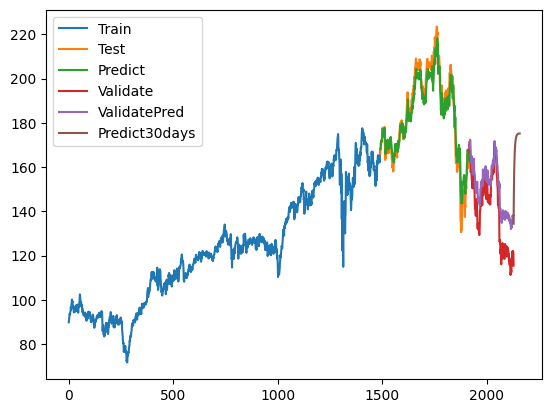

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()